# Web Voyager

THis is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard

source code: https://langchain-ai.github.io/langgraph/tutorials/web-navigation/web_voyager/

# Setup Environment
Set up the environment by importing necessary libraries and setting up API keys.

In [1]:
# # Install required packages
# !pip install --quiet langgraph langsmith langchain_openai playwright nest_asyncio
# # Install Playwright browser
# !playwright install

# Import necessary libraries
import os
import nest_asyncio

from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Apply nest_asyncio for running async code in Jupyter
nest_asyncio.apply()

# Define A Helper File

Make sure to create a JS code file called mark_page.js in the same folder as the notebook

# Define Agent State
Define the `AgentState` class to represent the state of the agent, including the webpage, bounding boxes, and predictions.

In [2]:
from typing import List, Optional, Any, Dict
from pydantic import BaseModel, Field, ConfigDict
from langchain_core.messages import BaseMessage
from playwright.async_api import Page
import base64
import asyncio

# Define the BBox model
class BBox(BaseModel):
    """
    Represents a bounding box on the webpage with its coordinates and metadata.
    """
    x: float
    y: float
    text: str
    type: str
    ariaLabel: Optional[str] = None
    id: Optional[str] = None

# Define the Prediction model
class Prediction(BaseModel):
    """
    Represents the agent's predicted action and its arguments.
    """
    action: str = Field(description="The action to be performed by the agent")
    args: List[str] = Field(default_factory=list, description="Arguments for the action")

# Define the AgentState model
class AgentState(BaseModel):
    """
    Represents the state of the agent during execution.
    """
    page: Any = Field(default=None, exclude=True)  # Non-serializable Playwright page object
    input: str = ""
    img: Optional[str] = ""
    bboxes: Optional[List[BBox]] = Field(default_factory=list, description="List of bounding boxes annotated on the webpage")
    prediction: Optional[Prediction] = Field(description="The agent's predicted action and arguments")
    scratchpad: Optional[List[BaseMessage]] = Field(default_factory=list, description="Intermediate steps or system messages")
    observation: Optional[str] = ""
    ids: Optional[List[int]] = Field(default_factory=list)

    class Config:
        # Exclude the `page` attribute during serialization
        arbitrary_types_allowed = True
        json_encoders = {
            Page: lambda v: None,  # Prevent serialization of arbitrary objects
        }


# Define Tools
Implement the tools for the agent, such as 

1. `click`, 

2. `type_text`, 

3. `scroll`, 

4. `wait`,

5. `go_back`, 

5. `to_google`.

In [3]:
import asyncio
import platform

#Tools
CLICK = "Click"
TYPE = "Type"
SCROLL = "Scroll"
WAIT = "Wait"
GOBACK = "Go_back"
GOOGLE = "Google"
APPROVE = "Approve"
ANSWER = "Answer"
RETRY = "Retry"


async def click(state: AgentState, name: str = CLICK):
    """
    Simulates a mouse click on a bounding box identified by its label.
    """
    try:
        page = state.page
        click_args = state.prediction.args
        print("Click args: ", click_args)
        if click_args is None or len(click_args) != 1:
            state.observation = f"Failed to click bounding box labeled as number {click_args}"
            return state
        bbox_id = int(click_args[0])
        print("Bbox ID clicked: ", bbox_id)
        try:
            bbox = state.bboxes[bbox_id]
            print("Bbox: ", bbox)
            state.ids.append(bbox_id)
        except IndexError:
            state.observation = f"Error: no bounding box for label {bbox_id}"
            return state
        x, y = bbox.x, bbox.y

        await page.mouse.click(x, y)
        state.observation = f"Clicked {bbox_id}"
    except Exception as e:
        state.observation = f"Error in {name} during click: {e}"
        print(f"Error in click: {e}")
    return state


async def type_text(state: AgentState, name: str = TYPE):
    """
    Simulates typing text into an input field identified by a bounding box label.
    """
    try:
        page = state.page
        type_args = state.prediction.args
        if type_args is None or len(type_args) != 2:
            state.observation = f"Failed to type in element from bounding box labeled as number {type_args}"
            return state
        bbox_id = int(type_args[0])
        text_content = type_args[1]
        try:
            bbox = state.bboxes[bbox_id]
        except IndexError:
            state.observation = f"Error: no bounding box for label {bbox_id}"
            return state
        x, y = bbox.x, bbox.y
        await page.mouse.click(x, y)
        select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
        await page.keyboard.press(select_all)
        await page.keyboard.press("Backspace")
        await page.keyboard.type(text_content)
        await page.keyboard.press("Enter")
        state.observation = f"Typed '{text_content}' and submitted"
    except Exception as e:
        state.observation = f"Error in {name} during type_text: {e}"
        print(f"Error in {name} when type_text: {e}")
    return state


async def scroll(state: AgentState, name: str = SCROLL):
    """
    Simulates scrolling within the webpage or a specific element.
    """
    try:
        page = state.page
        scroll_args = state.prediction.args
        if scroll_args is None or len(scroll_args) != 2:
            state.observation = "Failed to scroll due to incorrect arguments."
            return state
        target, direction = scroll_args

        if target.upper() == "WINDOW":
            scroll_amount = 500
            scroll_direction = (
                -scroll_amount if direction.lower() == "up" else scroll_amount
            )
            await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
        else:
            scroll_amount = 200
            target_id = int(target)
            try:
                bbox = state.bboxes[target_id]
                x, y = bbox.x, bbox.y
                await page.mouse.move(x, y)
                scroll_direction = (
                    -scroll_amount if direction.lower() == "up" else scroll_amount
                )
                await page.mouse.wheel(0, scroll_direction)
            except IndexError:
                state.observation = f"Error: no bounding box for label {target_id}"
                return state

        state.observation = f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"
    except Exception as e:
        state.observation = f"Error during scroll: {e}"
        print(f"Error in {name} when scroll: {e}")
    return state


async def wait(state: AgentState):
    """
    Simulates a wait action for a fixed duration.
    """
    try:
        sleep_time = 5
        await asyncio.sleep(sleep_time)
        state.observation = f"Waited for {sleep_time} seconds"
    except Exception as e:
        state.observation = f"Error during wait: {e}"
        print(f"Error in wait: {e}")
    return state


async def go_back(state: AgentState):
    """
    Simulates navigating back to the previous page in the browser.
    """
    try:
        page = state.page
        await page.go_back()
        state.observation = f"Navigated back to {page.url}"
    except Exception as e:
        state.observation = f"Error during go_back: {e}"
        print(f"Error in go_back: {e}")
    return state


async def to_google(state: AgentState):
    """
    Simulates navigating to the Google homepage.
    """
    try:
        page = state.page
        await page.goto("https://www.google.com/")
        state.observation = "Navigated to google.com"
    except Exception as e:
        state.observation = f"Error during to_google: {e}"
        print(f"Error in to_google: {e}")
    return state

async def approve_info_box(state: AgentState):
    """
    Simulates clicking the 'Approve' button in a Google information box.
    """
    try:
        page = state.page
        approve_args = state.prediction.args
        if approve_args is None or len(approve_args) != 1:
            state.observation = f"Failed to approve due to incorrect arguments: {approve_args}"
            return state
        bbox_id = int(approve_args[0])
        try:
            bbox = state.bboxes[bbox_id]
            print("Bbox: ", bbox)
        except IndexError:
            state.observation = f"Error: no bounding box for label {bbox_id}"
            return state
        x, y = bbox.x, bbox.y

        # Simulate clicking the 'Approve' button
        await page.mouse.click(x, y)
        state.observation = f"Clicked 'Approve' button for bounding box {bbox_id}"
    except Exception as e:
        state.observation = f"Error during approve_info_box: {e}"
        print(f"Error in approve_info_box: {e}")
    return state

In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Load the prompt template for the agent
prompt = hub.pull("wfh/web-voyager")

# Initialize the LLM with gpt-4o
#llm = ChatOpenAI(model="gpt-4o")

# Define the structured output schema
class StrOutput(BaseModel):
    """
    Represents the structured output of the LLM.
    """
    thought: str = Field(..., description="Your brief thoughts (briefly summarize the info that will help ANSWER)")
    action: str = Field(..., description="The action you want to take")
    args: list[str] = Field(..., description="The arguments for the action")

# Initialize the LLM with gpt-4o and structured output
structured_llm = ChatOpenAI(model="gpt-4o").with_structured_output(schema=StrOutput)

/home/teodorrk/projects/cogitoxinfor-agents/.myvenv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


# Define Browser Annotations
Define the `mark_page` function to annotate the browser page with bounding boxes for the agent to interact with.

# Define Agent
Compose the agent using the annotation function, prompt, LLM, and output parser.

In [5]:
import base64
from langchain_core.runnables import chain as chain_decorator

# Load the JavaScript code for annotating the page
with open("mark_page.js") as f:
    # Some JavaScript we will run on each step
    # to take a screenshot of the page, select the
    # elements to annotate, and add bounding boxes
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page):
    """
    Annotates the current browser page with bounding boxes for interactive elements,
    including elements inside iframes.
    """
    try:
        # Wait for the page to load completely
        await page.wait_for_load_state("domcontentloaded")

        # Execute the JavaScript code to annotate the page
        await page.evaluate(mark_page_script)

        # Retry logic to ensure bounding boxes are captured
        for _ in range(10):  # Retry up to 10 times in case of loading delays
            try:
                bboxes = await page.evaluate("markPage()")  # Get bounding boxes
                print("Bounding boxes:", bboxes)  # Debugging: Log bounding boxes
                break
            except Exception as e:
                print(f"Error during markPage execution: {e}")
                await asyncio.sleep(3)  # Wait before retrying
        else:
            raise Exception("Failed to get bounding boxes after 10 retries")

        # Take a screenshot of the page
        screenshot = await page.screenshot()

        # Remove annotations after capturing
        await page.evaluate("unmarkPage()")

        return {
            "img": base64.b64encode(screenshot).decode(),  # Encode screenshot as base64
            "bboxes": bboxes,  # Return bounding boxes
        }
    except Exception as e:
        print(f"Error in mark_page: {e}")
        raise


async def annotate(state):
    """
    Annotates the current page and processes bounding boxes for both the main page and iframes.
    """
    try:
        # Annotate the page and get bounding boxes
        marked_page = await mark_page.with_retry().ainvoke(state.page)
        print("Annotated bounding boxes:", marked_page["bboxes"])  # Log the bounding boxes

        # Set the annotated image and bounding boxes in the state
        state.img = marked_page["img"]
        state.bboxes = [
            BBox(**bbox) for bbox in marked_page["bboxes"]
        ]  # Convert bounding boxes to BBox objects

        # Check if any bounding box is of type 'iframe'
        iframe_bboxes = [bbox for bbox in marked_page["bboxes"] if bbox["type"] == "iframe"]
        for iframe_bbox in iframe_bboxes:
            src = iframe_bbox.get("src")
            if not src:
                print(f"Skipping iframe with no src: {iframe_bbox}")
                continue

            print(f"Iframe detected with src: {src}. Processing iframe...")
            try:
                # Switch to the iframe and annotate its content
                iframe = await state.page.frame_locator(f"iframe[src='{src}']").frame()
                iframe_marked_page = await mark_page.with_retry().ainvoke(iframe)
                print("Annotated iframe bounding boxes:", iframe_marked_page["bboxes"])

                # Combine iframe bounding boxes with the main page bounding boxes
                state.bboxes.extend([
                    BBox(**bbox) for bbox in iframe_marked_page["bboxes"]
                ])
            except Exception as iframe_error:
                print(f"Error processing iframe with src {src}: {iframe_error}")

    except Exception as e:
        print(f"Error in annotate: {e}")
        raise

    return state

In [6]:
from typing import Dict

#Dropping the format instructions in this system message 
# to avoid formatting issues with the structured output

def agent_routes(routes: Dict[str, str]) -> str:
    actions = ''.join([f"- {key}: {value} \n" for key, value in routes.items()])
    text = f"""
    Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. 
    In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. 
    This screenshot will feature Numerical Labels placed in the TOP LEFT corner of each Web Element. 
    Carefully analyze the visual information to identify the Numerical Label corresponding to the Web Element 
    that requires interaction, then follow the guidelines and choose one of the following actions:
    
    {actions}
    
    Key Guidelines You MUST follow:
    
    * Action guidelines *
    1) Execute only one action per iteration.
    2) When clicking or typing, ensure to select the correct bounding box.
    3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.
    4) If you encounter a cookie consent popup (e.g., "Godta alle"), click on it to proceed. Use scroll if the labels in the bottom are not visible."
    
    * Web Browsing Guidelines *
    1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
    2) Select strategically to minimize time wasted.
    
    Then the User will provide:
    Observation: A labeled screenshot Given by User

    Important information:

    """
    return text

# Define the routes
routes = {
    CLICK: "Click a Web Element. [Numerical_Label].",
    TYPE: "Delete existing content in a textbox and then type content. [Numerical_Label]; [Content].",
    SCROLL: "Scroll up or down. [Numerical_Label or WINDOW]; [up or down].",
    WAIT: "Wait.",
    GOBACK: "Go back.",
    GOOGLE: "Return to Google to start over.",
    ANSWER: "Respond with the final answer. [Content].",
    RETRY: "Retry the last action.",
}

from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)


input_prompt = {"type": "text", "text": "{input}"}

bbox_prompt = {"type": "text", "text": "{bbox_descriptions}"}

img_prompt = {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{img}"},
                }

new_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_routes(routes=routes)),
         MessagesPlaceholder("scratchpad", optional=True),
        ("human", [input_prompt]),
        ("human", [bbox_prompt]),
        ("human", [img_prompt]),
    ]
)

In [7]:
new_prompt

ChatPromptTemplate(input_variables=['bbox_descriptions', 'img', 'input'], optional_variables=['scratchpad'], input_types={'scratchpad': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(t

In [8]:
from langchain_core.messages import BaseMessage, SystemMessage
import base64
import asyncio


# Function to format bounding box descriptions
def format_descriptions(state: AgentState) -> None:
    """
    Formats the bounding box descriptions for the agent's prompt and updates the scratchpad.
    """
    labels = []
    for i, bbox in enumerate(state.bboxes):
        text = bbox.ariaLabel or bbox.text
        el_type = bbox.type
        labels.append(f'{i} (<{el_type}/>): "{text}"')

    # Wrap the description in a SystemMessage
    description_message = SystemMessage(content="Valid Bounding Boxes:\n" + "\n".join(labels))
    state.scratchpad.append(description_message)

    return state


# Main agent function
async def agent(state: AgentState) -> AgentState:
    """
    Main function to run the agent.
    """
    try:

        # Step 1: Generate the prompt text
        prompt_text = new_prompt.invoke({
            "bbox_descriptions": state.bboxes,
            "img": state.img,  # Correctly embed the Base64-encoded image
            "input": state.input,
            "scratchpad": state.scratchpad,
        })

        # Print the prompt text for debugging
        print("Prompt Text: ", prompt_text)

        # Step 2: Get the LLM response
        response = await structured_llm.ainvoke(prompt_text)
        prediction = Prediction(action=response.action, args=response.args)
        print("Prediction: ", prediction)

        # Step 3: Update the agent state with the prediction
        state.prediction = prediction

        return state

    except Exception as e:
        print(f"Error in agent function: {e}")
        raise

# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.

In [9]:
from langchain_core.messages import SystemMessage
import re

def update_scratchpad(state: AgentState) -> AgentState:
    """
    Updates the scratchpad with the results of the agent's previous actions.
    """
    try:
        print("Updating scratchpad with observation: ", state.observation)
        # Get the current scratchpad content
        old_scratchpad = state.scratchpad
        print("Current scratchpad: ", old_scratchpad)
        if old_scratchpad:
            # Extract the last step number from the scratchpad
            txt = old_scratchpad[0].content
            last_line = txt.rsplit("\n", 1)[-1]
            step = int(re.match(r"\d+", last_line).group()) + 1
        else:
            # Initialize the scratchpad if it's empty
            txt = "Previous action observations:\n"
            step = 1

        # Append the latest observation to the scratchpad
        txt += f"\n{step}. {state.observation}"
        print("Updated scratchpad: ", txt)
        # Update the state with the new scratchpad
        state.scratchpad = [SystemMessage(content=txt)]
        return state
    except Exception as e:
        print(f"Error in update_scratchpad: {e}")
        raise

In [10]:
from IPython.display import display, Image
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal

AGENT = "agent"
FORMAT_DESCRIPTIONS = "format_descriptions"
ANNOTATE_PAGE = "annotate_page"
UPDATE_SCRATCHPAD = "update_scratchpad"

builder = StateGraph(AgentState)

builder.add_node(AGENT, agent)
builder.add_node(ANNOTATE_PAGE, annotate)
builder.add_node(FORMAT_DESCRIPTIONS, format_descriptions)
builder.add_node(UPDATE_SCRATCHPAD, update_scratchpad)

builder.add_edge(START, ANNOTATE_PAGE)
builder.add_edge(ANNOTATE_PAGE, FORMAT_DESCRIPTIONS)
builder.add_edge(FORMAT_DESCRIPTIONS, AGENT)


builder.add_edge(UPDATE_SCRATCHPAD, ANNOTATE_PAGE)

tools = {
    CLICK: click,
    TYPE: type_text,
    SCROLL: scroll,
    WAIT: wait,
    GOBACK: go_back,
    GOOGLE: to_google,
    APPROVE: approve_info_box,
}


for tool_name, tool_func in tools.items():
    builder.add_node(tool_name, tool_func)
    builder.add_edge(tool_name, UPDATE_SCRATCHPAD)


nodes = Literal[
    CLICK,
    TYPE,
    SCROLL,
    WAIT,
    GOBACK,
    GOOGLE,
    APPROVE,
    UPDATE_SCRATCHPAD,
    END,
    ANNOTATE_PAGE,
]

def select_tool(state: AgentState) -> nodes:
    action = state.prediction.action
    if action == ANSWER:
        return END
    if action == RETRY:
        print("Retrying...")
        return ANNOTATE_PAGE
    return action

builder.add_conditional_edges(AGENT, select_tool)

memory = MemorySaver()
#graph = builder.compile(checkpointer=memory)
graph = builder.compile()
print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	annotate_page(annotate_page)
	format_descriptions(format_descriptions)
	update_scratchpad(update_scratchpad)
	Click(Click)
	Type(Type)
	Scroll(Scroll)
	Wait(Wait)
	Go_back(Go_back)
	Google(Google)
	Approve(Approve)
	__end__([<p>__end__</p>]):::last
	Approve --> update_scratchpad;
	Click --> update_scratchpad;
	Go_back --> update_scratchpad;
	Google --> update_scratchpad;
	Scroll --> update_scratchpad;
	Type --> update_scratchpad;
	Wait --> update_scratchpad;
	__start__ --> annotate_page;
	annotate_page --> format_descriptions;
	format_descriptions --> agent;
	update_scratchpad --> annotate_page;
	agent -.-> Click;
	agent -.-> Type;
	agent -.-> Scroll;
	agent -.-> Wait;
	agent -.-> Go_back;
	agent -.-> Google;
	agent -.-> Approve;
	agent -.-> update_scratchpad;
	agent -.-> __end__;
	agent -.-> annotate_page;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-op

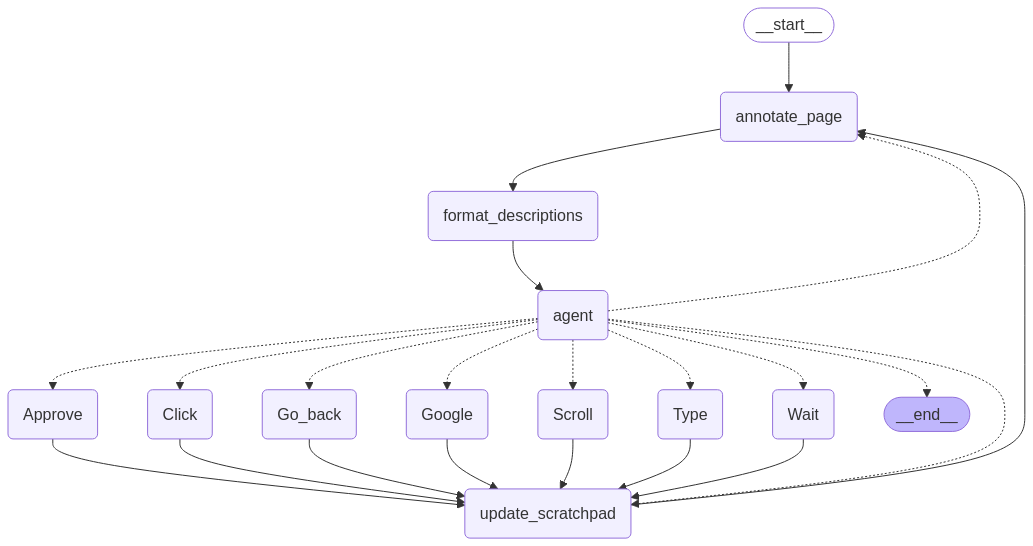

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from IPython import display
from playwright.async_api import async_playwright
import asyncio
import uuid
import base64

config ={
    "thread_id": str(uuid.uuid4()),
    "recursion_limit": 150,
    }

# Run the agent
async def test_agent(query: str, config: dict = config):
    # Start Playwright
    playwright = await async_playwright().start()

    # Launch the browser
    browser = await playwright.chromium.launch(
        executable_path="/usr/bin/chromium-browser",
        headless=False,  # Set to False to watch the agent navigate
        args=[
            '--no-sandbox',
            '--disable-blink-features=AutomationControlled',
        ],
    )

    # Open a new page
    page = await browser.new_page()

    # Navigate to Google
    await page.goto("https://www.google.com")
    await page.wait_for_selector("text=Godta alle", timeout=5000)  # Wait up to 5 seconds
    await page.click("text=Godta alle") 

    # Create an initial AgentState
    state = AgentState(
        page=page,
        input=query,
        img=None,
        bboxes=[],
        prediction=None,
        scratchpad=[],
        observation=None,
        ids=[]
    )

    # Run the agent
    try:
        # Iterate over the asynchronous generator
        event_stream = graph.astream(
            state,
            config=config,
        )

        final_answer = None
        steps = []
        async for event in event_stream:
            # Log relevant event details
            if "agent" in event:
                print("\n--- Agent Event ---")
                pred = event["agent"].get("prediction") or {}
                action = pred.action
                action_input = pred.args
                print(f"Action: {action}")
                print(f"Action Input: {action_input}")
                print(f"Observation: {event['agent'].get('observation')}")
                print(f"Scratchpad: {event['agent'].get('scratchpad', [])}")
                print(f"Bounding Boxes: {event['agent'].get('bboxes', [])}")
                print(f"Image: {event['agent'].get('img')}")
                display.clear_output(wait=True)
                steps.append(f"{len(steps) + 1}. {action}: {action_input}")
                print("\n".join(steps))
                display.display(display.Image(base64.b64decode(event["agent"]["img"])))
                if action == "ANSWER":
                    print(f"\nFinal answer: {action_input[0]}")
                    final_answer = action_input[0]
                    break

        print("Agent completed successfully.")
    finally:
        # Close the browser
        await browser.close()
        await playwright.stop()

    return final_answer

1. Click: ['2']
2. Click: ['2']
3. Type: ['6', 'finn.no']
4. Click: ['26']
5. Click: ['1']
6. Click: ['26']
7. Click: ['Godta alle']
8. Click: ['Godta alle']
9. Click: ['Godta alle']
10. Click: ['Godta alle']
11. Click: ['Godta alle']
12. Click: ['Godta alle']
13. Type: ['1', 'BMW iX xDrive40 2022']
14. Click: ['5']
15. Type: ['12; BMW iX xDrive40 2022']
16. Click: ['10']
17. Type: ['37', 'BMW iX xDrive40 2022']
18. Click: ['10']
19. Click: ['10']
20. Click: ['10']
21. Click: ['10']
22. Click: ['12']
23. Click: ['0']
24. Click: ['21']
25. Click: ['10']
26. Scroll: ['WINDOW', 'down']
27. Click: ['10']
28. Click: ['10']
29. Click: ['10']
30. Click: ['21']


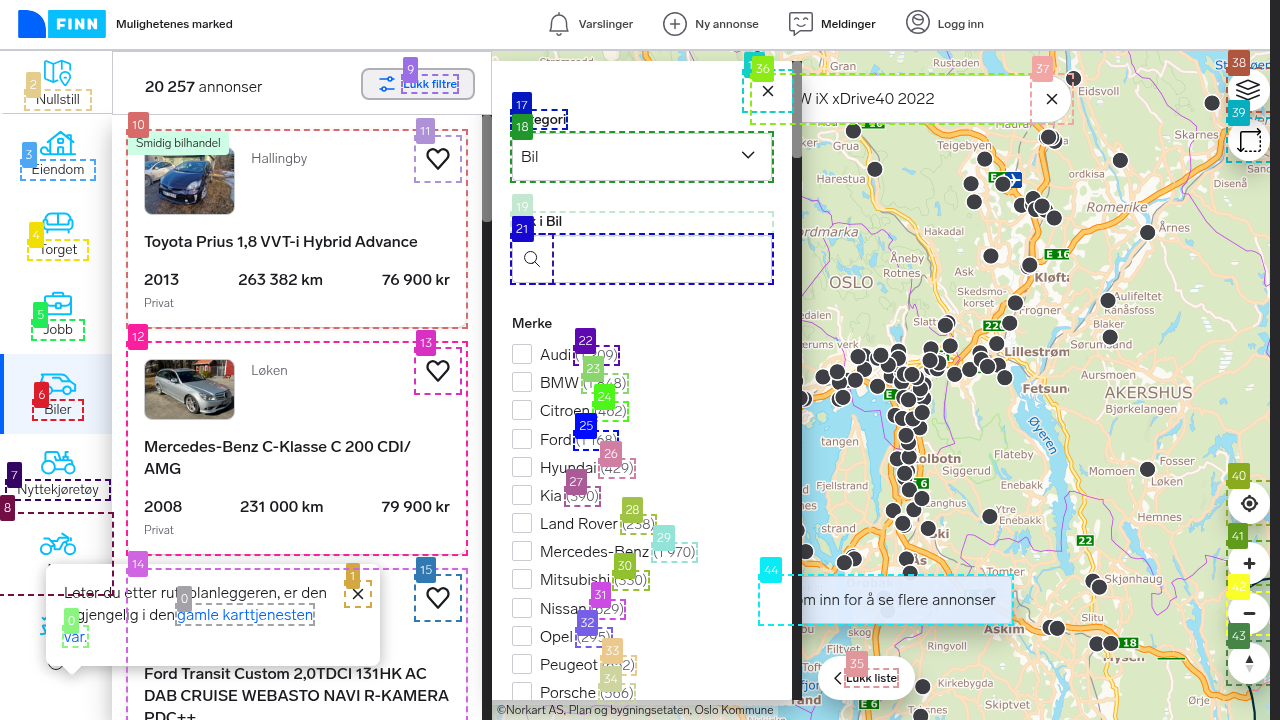

Click args:  ['21']
Bbox ID clicked:  21
Bbox:  x=532.0 y=259.0 text='Forstørrelsesglass' type='button' ariaLabel='Søk' id=None
Updating scratchpad with observation:  Clicked 21
Current scratchpad:  [SystemMessage(content='Valid Bounding Boxes:\n0 (<div/>): "no"\n1 (<div/>): "Logg på"\n2 (<a/>): "informasjonskapsler"\n3. Clicked 2\n4. Clicked 2\n5. Typed \'finn.no\' and submitted\n6. Clicked 26\n7. Clicked 1\n8. Clicked 26\n9. Error in Click during click: invalid literal for int() with base 10: \'Godta alle\'\n10. Error in Click during click: invalid literal for int() with base 10: \'Godta alle\'\n11. Error in Click during click: invalid literal for int() with base 10: \'Godta alle\'\n12. Error in Click during click: invalid literal for int() with base 10: \'Godta alle\'\n13. Error in Click during click: invalid literal for int() with base 10: \'Godta alle\'\n14. Error in Click during click: invalid literal for int() with base 10: \'Godta alle\'\n15. Typed \'BMW iX xDrive40 2022\' and 

GraphRecursionError: Recursion limit of 150 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [13]:
# Run the test
res = await test_agent(
query=""""
Go to finn.no and search for 'BMW iX xDrive40 2022'. 
Click on the first result and scroll down to see the details.
"""  
)

In [ ]:
state_values = graph.get_state(config=config).values
state_values

{}

# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.